In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import scipy
import seaborn as sns

In [3]:
gland1 = 'MG'
gland2 = 'AG'
dataset = 'S-MAG'
celltype_column = 'newcelltype'
gland_column = 'gland'
n_top_genes=5000

In [4]:
#adata = sc.read_h5ad(f"D:/111/{dataset}_cleaned.h5ad")  

MemoryError: Unable to allocate 268. MiB for an array with shape (70298075,) and data type int32

In [4]:
adata = sc.read_h5ad(f"../1.harmony/{dataset}_cleaned.h5ad")  

In [5]:
adata.X = adata.layers['counts']

In [ ]:
adata.obs['newcelltype'] = (adata.obs['newcelltype'].astype(str) + '-' +  adata.obs[gland_column].astype(str))

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=n_top_genes)
adata = adata[:, adata.var.highly_variable]
#sc.pp.scale(adata, max_value=10)

In [6]:
adata_A = adata[adata.obs[gland_column]==gland1]
adata_B = adata[adata.obs[gland_column]==gland2]

In [7]:
adata_A

View of AnnData object with n_obs × n_vars = 16140 × 12071
    obs: 'species', 'n_genes_by_counts', 'total_counts', 'doublet_score', 'predicted_doublet', 'sample', 'gland', 'stage', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'total_counts_MT', 'pct_counts_MT', 'log1p_total_counts_MT', 'total_counts_RIBO', 'pct_counts_RIBO', 'log1p_total_counts_RIBO', 'leiden', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'newcelltype', 'glandbatch'
    var: 'MT', 'RIBO', 'n_cells_by_counts', 'total_counts', 'mean_counts', 'pct_dropout_by_counts', 'log1p_total_counts', 'log1p_mean_counts', 'highly_variable_rank', 'variances', 'variances_norm', 'highly_variable_nbatches', 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'celltype_colors',

In [8]:
cell_types_A = adata_A.obs[celltype_column].unique()
cell_types_B = adata_B.obs[celltype_column].unique()

In [9]:
correlation_results = []

for celltype_A in cell_types_A:
    for celltype_B in cell_types_B:
        if celltype_A == celltype_B:
            continue

        print(f"current celltype: {celltype_A} vs {celltype_B}")

        # 选出 gland1 + celltype_A
        subset_gland1 = adata[
            (adata.obs[celltype_column] == celltype_A) &
            (adata.obs[gland_column] == gland1)
        ]

        # 选出 gland2 + celltype_B
        subset_gland2 = adata[
            (adata.obs[celltype_column] == celltype_B) &
            (adata.obs[gland_column] == gland2)
        ]

        # 确保子集非空
        if subset_gland1.shape[0] > 0 and subset_gland2.shape[0] > 0:
            # 直接将 NaN 替换为 0
            # 注意：这一步会改写 subset_gland1.X 和 subset_gland2.X 的底层数据
            subset_gland1.X = np.nan_to_num(subset_gland1.X, nan=0.0)
            subset_gland2.X = np.nan_to_num(subset_gland2.X, nan=0.0)

            # 重新计算均值表达向量
            mean_expression_gland1 = np.asarray(subset_gland1.X.mean(axis=0)).flatten()
            mean_expression_gland2 = np.asarray(subset_gland2.X.mean(axis=0)).flatten()

            # 计算 Spearman 相关及 p 值
            corr, pval = spearmanr(mean_expression_gland1, mean_expression_gland2,nan_policy='omit')

            correlation_results.append({
                'cell_type_A': celltype_A,
                'cell_type_B': celltype_B,
                'correlation': corr,
                'p-value': pval
            })

# 整理结果并过滤 p < 0.05
correlation_df = pd.DataFrame(correlation_results).dropna()
#correlation_df = correlation_df[correlation_df['p-value'] < 0.1]
print(correlation_df)


C:\Users\Lenovo\miniconda3\envs\py310\lib\site-packages\anndata\_core\anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


    stage  cell_type  correlation  p-value
0  stage2  StemCells     0.847429      0.0
1  stage2      LumHR     0.870341      0.0
2  stage4  StemCells     0.835516      0.0
3  stage4      LumHR     0.899258      0.0
4  stage1  StemCells     0.868090      0.0
5  stage1      LumHR     0.690609      0.0
6  stage1   Lum-Krt1     0.928592      0.0
7  stage3  StemCells     0.861522      0.0
8  stage3      LumHR     0.898867      0.0
9  stage3   Lum-Krt1     0.729418      0.0


In [ ]:
correlation_df.to_csv("correlation_results.csv", index=False)

In [11]:
# ===== 绘制热图部分 =====
# 1) 将长表格 (long format) 转成矩阵形式 (wide format)
#    行为 cell_type_A，列为 cell_type_B，矩阵值为 correlation
correlation_matrix = correlation_df.pivot(
    index='cell_type_A',
    columns='cell_type_B',
    values='correlation'
)

# 2) 使用 matplotlib 绘制热图
fig, ax = plt.subplots()

# imshow 可以可视化二维数据；默认颜色映射即可
im = ax.imshow(correlation_matrix)

# 设置坐标轴刻度与标签
ax.set_xticks(np.arange(len(correlation_matrix.columns)))
ax.set_yticks(np.arange(len(correlation_matrix.index)))
ax.set_xticklabels(correlation_matrix.columns)
ax.set_yticklabels(correlation_matrix.index)

# 让 X 轴标签旋转，防止重叠
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

# 可选：在每个热图单元格中显示相关系数数值
for i in range(len(correlation_matrix.index)):
    for j in range(len(correlation_matrix.columns)):
        value = correlation_matrix.iloc[i, j]
        # 若该单元格不是 NaN，则绘制文字
        if not np.isnan(value):
            ax.text(j, i, f"{value:.2f}", ha="center", va="center", color="black")

# 添加颜色条
plt.colorbar(im)

# 设置标题
plt.title(f"Spearman Correlation Heatmap in {dataset}") 

# 调整布局
plt.tight_layout()

# 保存图片
plt.savefig(f"{dataset}-celltype_correlation_heatmap.png", dpi=300)

# 显示图片
plt.show()

# ===== 3) 若需要同时保存结果DataFrame =====
correlation_df.to_csv(f"{dataset}-celltype_correlation_results.csv", index=False)

,stage,cell_type,correlation,p-value,Percentage
0,stage2,StemCells,0.847429,0.0,17.961216
1,stage2,LumHR,0.870341,0.0,31.800360
2,stage4,StemCells,0.835516,0.0,2.111252
3,stage4,LumHR,0.899258,0.0,41.896334
4,stage1,StemCells,0.868090,0.0,72.922956
5,stage1,LumHR,0.690609,0.0,0.367502
6,stage1,Lum-Krt1,0.928592,0.0,18.283239
7,stage3,StemCells,0.861522,0.0,3.422440
8,stage3,LumHR,0.898867,0.0,41.309777
9,stage3,Lum-Krt1,0.729418,0.0,4.356674


In [4]:
#correlation_df=pd.read_csv("./S-MAG-celltype_correlation_results.csv")
#correlation_df

,cell_type_A,cell_type_B,correlation,p-value
0,Basal-MG,LumSEC-MG-like-AG,-0.212204,6.884767e-32
1,Basal-MG,Epi-Ker-AG,-0.093705,2.723578e-07
2,Basal-MG,LumSEC-Lip-AG,-0.431886,1.358271e-136
3,Basal-MG,Epi-Pro-AG,-0.188347,2.348626e-25
4,Basal-MG,ASC-t2-AG,-0.119287,5.589310e-11
...,...,...,...,...
75,MaSC-Basal-MG,Basal-AG,-0.115502,2.225581e-10
76,MaSC-Basal-MG,Lum-t2-AG,0.056019,2.144778e-03
77,MaSC-Basal-MG,ASC-AG,0.381627,1.291731e-104
78,MaSC-Basal-MG,Lum-K18-AG,0.204251,1.282762e-29


NameError: name 'dataset' is not defined

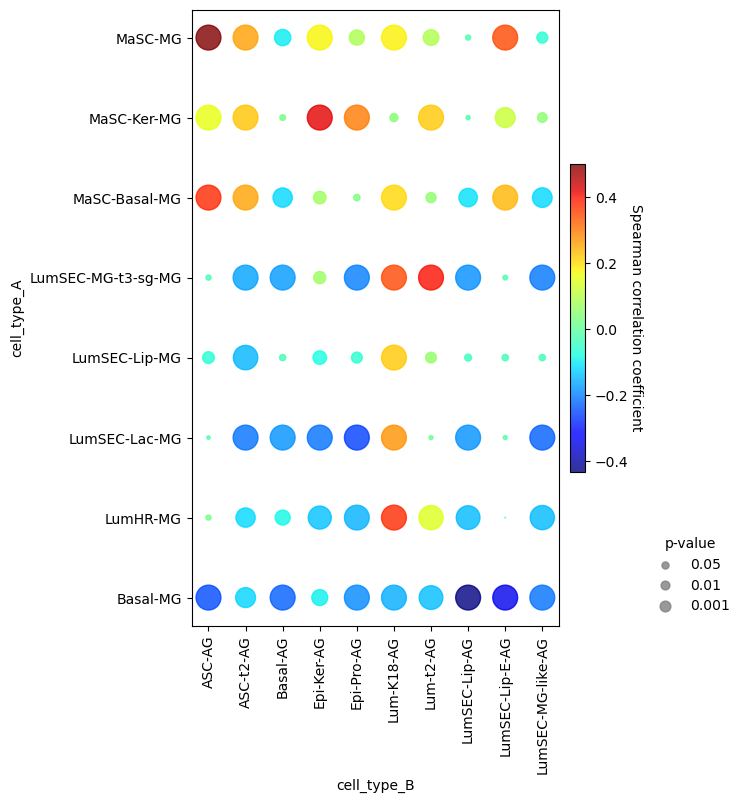

In [17]:
# 假设在脚本其他位置，你已获得 correlation_df，并且 import 了 matplotlib 等库

# 1) 提取并排序 cell_type_A / cell_type_B
unique_celltype_A = sorted(correlation_df['cell_type_A'].unique())
unique_celltype_B = sorted(correlation_df['cell_type_B'].unique())

# 2) 将 cell_type_A, cell_type_B 映射到数值索引
x_positions = correlation_df['cell_type_B'].apply(lambda x: unique_celltype_B.index(x))
y_positions = correlation_df['cell_type_A'].apply(lambda y: unique_celltype_A.index(y))

# 3) 颜色和点大小
colors = correlation_df['correlation'].values
sizes = 20 * -np.log10(correlation_df['p-value'] + 1e-16)

# --- 绘图开始 ---
fig, ax = plt.subplots(figsize=(8, 8))

# 绘制散点图
scatter = ax.scatter(
    x_positions,
    y_positions,
    c=colors,
    s=sizes,
    cmap="jet",
    alpha=0.8
)

# 动态设置 colorbar 的取值范围
vmin, vmax = colors.min(), colors.max()
scatter.set_clim(vmin, vmax)

# 让右侧留足空间，方便放 colorbar 和 p-value 图例
plt.subplots_adjust(right=0.8)  # 可适当调大或调小

# 在右侧添加 colorbar（放在上方）
# - fraction: colorbar 相对于主绘图区 Axes 的长度比例（越小越短）
# - pad: colorbar 与 Axes 之间的空隙
# - shrink: 进一步全局缩短 colorbar
cbar = plt.colorbar(scatter, ax=ax, fraction=0.3, pad=0.02, shrink=0.5)
cbar.set_label("Spearman correlation coefficient", rotation=270, labelpad=10)

# 坐标轴刻度和标签
ax.set_xticks(range(len(unique_celltype_B)))
ax.set_yticks(range(len(unique_celltype_A)))
ax.set_xticklabels(unique_celltype_B, rotation=90)
ax.set_yticklabels(unique_celltype_A)
ax.set_xlabel("cell_type_B")
ax.set_ylabel("cell_type_A")

# p-value 图例（点大小说明），放在右下方
p_legend_values = [0.05, 0.01, 0.001]
handles, labels = [], []
for pval in p_legend_values:
    s = 20 * -np.log10(pval + 1e-16)
    handles.append(ax.scatter([], [], s=s, color='gray', alpha=0.8))
    labels.append(f"{pval:g}")

legend_title = "p-value"
ax.legend(
    handles,
    labels,
    title=legend_title,
    loc="lower right",       # 将图例放在主绘图区的右下角
    bbox_to_anchor=(1.5, 0),# (x=1.25)表示再向外留些空间，防止与图挤在一起
    frameon=False            # 去掉图例方框
)

# 标题与保存
plt.title(f"Dotplot of Spearman Correlation in {dataset}")
plt.tight_layout()
plt.savefig(f"{dataset}-celltype_correlation_dotplot.png", dpi=300)
plt.show()
